### Import libraries

In [1]:
import torch
import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

import matplotlib.pyplot as plt
import seaborn as sn

import numpy as np
import pandas as pd
import itertools
import os
import random
from PIL import Image
from sklearn.metrics import jaccard_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Create transformations pipeline

In [3]:
img_transforms = T.Compose([
    T.ToTensor(),
    T.GaussianBlur(5),
    T.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((400,400)),
])


mask_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((400,400))
])

### Creating General Dataset

In [4]:
root_dir = '/content/drive/MyDrive/tfm/Datasets/CBIS-DDSM'
mask_dir = os.path.join(root_dir, "MASKS")
img_dir = os.path.join(root_dir, "IMAGES")
        
file_names = os.listdir(img_dir)
img_paths = [os.path.join(img_dir, img_name) for img_name in file_names]

images = []
masks = []

for img in img_paths:
    mask_file_name = img.split(".")[0]
    mask_file_name = mask_file_name.split("_")
    mask_file_name[-1] = "MASK"
    mask_file_name = "_".join(mask_file_name) + ".png"
    mask_file_name  = mask_file_name.split("/")[-1]
    mask_path = os.path.join(mask_dir, mask_file_name)

    mask, image = Image.open(mask_path).convert("L"), Image.open(img).convert('RGB')

    image = img_transforms(image)
    mask = mask_transforms(mask)

    mask, image = mask.float(), image.float()
    mask[mask > 0 ] = 1

    images.append(image)
    masks.append(mask)


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [5]:
img_array = [t.numpy() for t in images]
img_array = np.array(img_array)

msk_array = [t.numpy() for t in masks]
msk_array = np.array(msk_array)

In [6]:
images = torch.Tensor(img_array)
masks = torch.Tensor(msk_array)

In [7]:
masks.shape

torch.Size([41, 1, 400, 400])

In [8]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(images,masks)

### Visualising Dataset

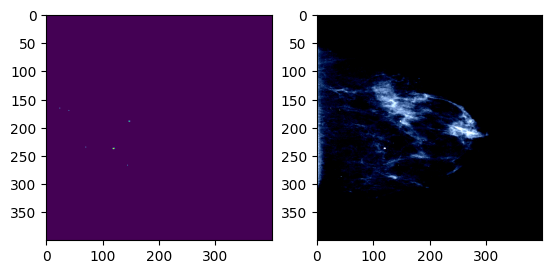

In [9]:
mask, img = dataset[8]

fig, ax = plt.subplots(nrows=1, ncols=2)

pos1 = ax[0].imshow(img.permute((1, 2, 0)))
pos2 = ax[1].imshow(mask.permute((1, 2, 0)))

### Splitting Dataset for Training & Validation

In [10]:
dataset_train, dataset_val = random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])
print(len(dataset_train), len(dataset_val))

32 9


### Dataloaders

In [11]:
dataloader_train = DataLoader(dataset_train, batch_size = 16)
dataloader_val = DataLoader(dataset_val, batch_size = 16)

### Defining Model

In [14]:
def create_model(outputchannels=1):
    model = models.segmentation.deeplabv3_resnet50(pretrained=True,
                                                    progress=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    return model

### Training

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(1).to(device)
criterion =  nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 500

def train(model, dataloader):
    model.train()
    train_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        

        loss = criterion(out, masks)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss/ len(dataloader)

def test(model, dataloader):
    model.eval()
    test_loss = 0
    train_iou = 0
    for data in dataloader:        
        images, masks = data[0].to(device), data[1].to(device)
        out = model(images)['out']
        
        loss = criterion(out, masks)
        test_loss += loss.item()
        
        train_iou += jaccard_score(masks.detach().cpu().flatten().numpy(), 
                      out.detach().cpu().flatten().numpy() > 0.01)
        
    return test_loss/ len(dataloader), train_iou / len(dataloader)

train_loss_lst = []
test_loss_lst = []
for epoch in range(epochs):
    train_loss = train(model, dataloader_train)
    train_loss_lst.append(train_loss)

    val_loss, val_iou = test(model, dataloader_val)
    test_loss_lst.append(val_loss)
    
    print('Epoch [{}/{}], Train loss: {:.4f}, Val loss {:.4f}, Val IoU {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, val_iou))    

Epoch [1/500], Train loss: 0.6986, Val loss 3156455754563584.0000, Val IoU 0.0006
Epoch [2/500], Train loss: 0.3234, Val loss 6062120894464.0000, Val IoU 0.0000
Epoch [3/500], Train loss: 0.0520, Val loss 292972363776.0000, Val IoU 0.0000
Epoch [4/500], Train loss: 0.0170, Val loss 5546752512.0000, Val IoU 0.0000
Epoch [5/500], Train loss: 0.0064, Val loss 135452080.0000, Val IoU 0.0000
Epoch [6/500], Train loss: 0.0038, Val loss 409528.8125, Val IoU 0.0000
Epoch [7/500], Train loss: 0.0031, Val loss 10338.5312, Val IoU 0.0000
Epoch [8/500], Train loss: 0.0028, Val loss 924.1587, Val IoU 0.0000
Epoch [9/500], Train loss: 0.0028, Val loss 149.4679, Val IoU 0.0000
Epoch [10/500], Train loss: 0.0027, Val loss 32.0878, Val IoU 0.0000
Epoch [11/500], Train loss: 0.0027, Val loss 7.3941, Val IoU 0.0000
Epoch [12/500], Train loss: 0.0029, Val loss 1.8095, Val IoU 0.0000
Epoch [13/500], Train loss: 0.0028, Val loss 0.4103, Val IoU 0.0000
Epoch [14/500], Train loss: 0.0028, Val loss 0.1538, Val

KeyboardInterrupt: ignored

### Visualise Loss

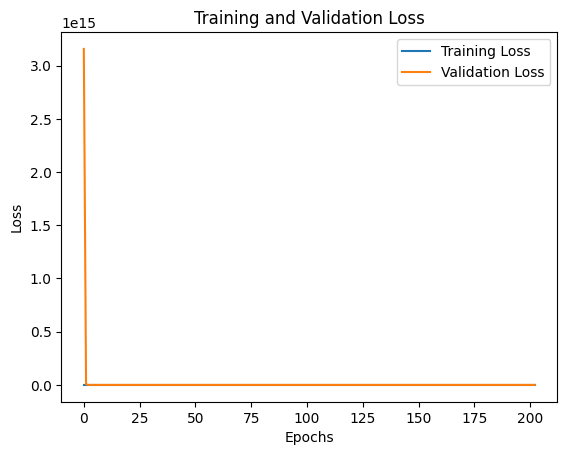

In [16]:
plt.plot(train_loss_lst, label='Training Loss')
plt.plot(test_loss_lst, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()

### Visualise Segmentation

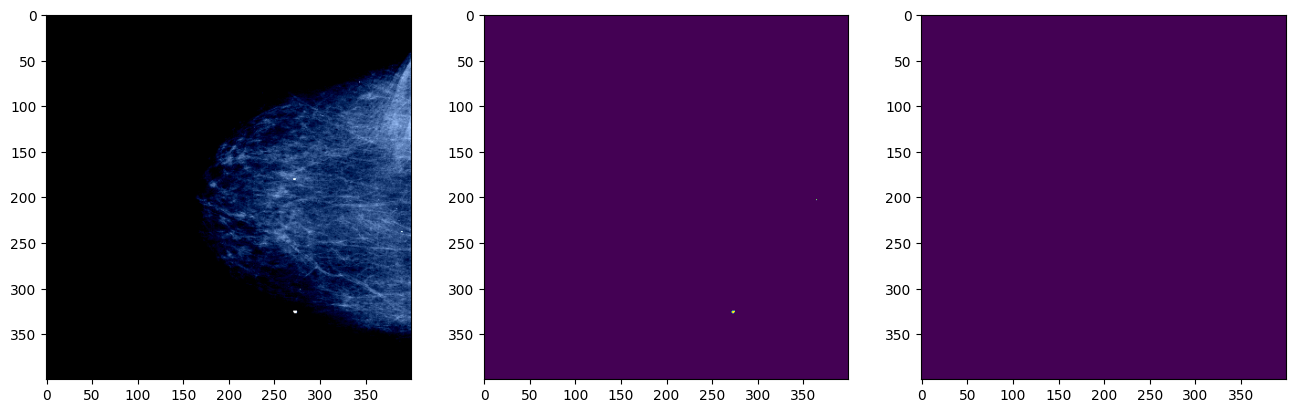

In [17]:
dataiter = iter(dataloader_train)
images, masks = next(dataiter)

images = images.to(device)
output = model(images)['out']

image_indx = 5
thresh_img = output[image_indx].cpu().detach() > 0.99

fig, axs = plt.subplots(1, 3, figsize=(16,9))
axs[0].imshow(images[image_indx].cpu().permute((1, 2, 0)))
axs[1].imshow(masks[image_indx].cpu().permute((1, 2, 0)))
axs[2].imshow(thresh_img.permute((1, 2, 0)))